In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_palette("husl")

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Collecting the data

In [2]:
df = pd.read_csv('acs2015_county.csv')

In [3]:
df.columns

Index(['CensusId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Citizen', 'Income',
       'IncomePerCap', 'Poverty', 'ChildPoverty', 'Professional', 'Service',
       'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed',
       'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork',
       'Unemployment_2016', 'Unemployment_var', 'CensusId.1', 'Rural-urban',
       'Urban Influence', 'less_highschool', 'highschool', 'some_college',
       'bachellor', 'Med_HH_Income', 'Economic_typology',
       'R_INTERNATIONAL_MIG', 'R_DOMESTIC_MIG', 'GOP Votes', 'DNC Votes'],
      dtype='object')

**'acs2015_county.csv'** is a table with all U.S. counties and some demographics data by county. 

Some of the demographic data in this file are the percentage of population by race, Income-related metrics, kind of work and unemployment between the county residents, how rural or urban the county is, how the county residents reach their job position, the level of education, the rate of immigrants between the county residents. Finally, the file also contains the results of the **2016 Presidential Elections**, which is the variable we want to forecast. 


In [4]:
df.head(5)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,less_highschool,highschool,some_college,bachellor,Med_HH_Income,Economic_typology,R_INTERNATIONAL_MIG,R_DOMESTIC_MIG,GOP Votes,DNC Votes
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,12.417,34.331,28.660,24.593,117.7,0,0.272440,4.831269,0.734358,0.239569
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,9.972,28.692,31.788,29.547,121.9,5,0.823643,20.493601,0.773515,0.195653
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,26.236,34.927,25.969,12.868,71.0,3,-0.192167,-18.755525,0.522714,0.466603
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,19.302,41.816,26.883,12.000,93.0,0,0.885073,-1.416117,0.769662,0.214220
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,19.969,32.942,34.039,13.050,102.0,0,1.076838,-1.736835,0.898519,0.084699


In [5]:
df_r = pd.read_csv('religious.csv')
df_r.head(2)

,FIPS,TOTRATE,EVANRATE
0,1001,676.878889,503.990000
1,1003,531.740000,318.138889


df_r file contains data with the rate of overall religious affiliation by county. There was also information about the especific denomination, but I pre-procesed the data and I removed all but the overall religious affilitiation and the rate of Evangelicals in the county


In [6]:
#I merged the religious data with the original data frame
df= df.merge(df_r, left_on='CensusId', right_on='FIPS', how='left')

In [7]:
df_c = pd.read_csv('CountyTypology.csv')
df_c.sample(4)

,FIPStxt,Farming,Mining,Manufacturing,Government,Recreation,Nonspecialized,Low_Education,Low_Employment,Pop_Loss,Retirement_Dest,Persistent_Poverty,Persistent_Related_Child_Poverty
1765,33003,0,0,0,0,1,0,0,0,0,1,0,0
2379,46037,1,0,0,0,0,0,0,0,1,0,0,0
360,12083,0,0,0,0,0,1,0,1,0,1,0,1
1492,29019,0,0,0,1,0,0,0,0,0,0,0,0


df_c contains binary information describing socio-demographics characteristics by county. The data is in a binary way, a county either has that characteristic or it hasn't. 

In [8]:
df= df.merge(df_c, left_on='CensusId', right_on='FIPStxt', how='left')

In [9]:
df_d = pd.read_csv('divisions.csv')
df_d.sample(5)

,Region,State (FIPS),Division 2,Name,Division
43,4,35,8,New Mexico,Mountain Division
18,2,31,4,Nebraska,West North Central Division
19,2,38,4,North Dakota,West North Central Division
24,3,13,5,Georgia,South Atlantic Division
50,4,53,9,Washington,Pacific Division


The census also has a division system that describes regions of America (like New England or Sout Atlantic Division), I will use this nomenclature to create a new Division feature


In [10]:
# I will create a category, I used the number before and it didn't help.
df_d = df_d.drop(['Region', 'State (FIPS)', 'Division 2'], axis=1)

In [11]:
df = df.merge(df_d, left_on='State', right_on='Name', how='left')

# Processing/Cleanning the data

In [12]:
#For how many counties I am missing some data
df.isna().sum()

CensusId                             0
State                                0
County                               0
TotalPop                             0
Men                                  0
Women                                0
Hispanic                             0
White                                0
Black                                0
Native                               0
Asian                                0
Pacific                              0
Citizen                              0
Income                               1
IncomePerCap                         0
Poverty                              0
ChildPoverty                         0
Professional                         0
Service                              0
Office                               0
Construction                         0
Production                           0
Drive                                0
Carpool                              0
Transit                              0
Walk                     

There are 79 counties which I am missing most of the data including the target variable. 

In [13]:
df[df['GOP Votes'].isnull()]

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Recreation,Nonspecialized,Low_Education,Low_Employment,Pop_Loss,Retirement_Dest,Persistent_Poverty,Persistent_Related_Child_Poverty,Name,Division
3140,72001,Puerto Rico,Adjuntas,18962,9266,9696,99.8,0.2,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3141,72003,Puerto Rico,Aguada,40603,19912,20691,93.6,3.4,0.1,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3142,72005,Puerto Rico,Aguadilla,57973,28267,29706,96.1,1.7,0.2,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3143,72007,Puerto Rico,Aguas Buenas,27693,13520,14173,99.2,0.8,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3144,72009,Puerto Rico,Aibonito,24829,12000,12829,99.8,0.2,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3145,72011,Puerto Rico,A�asco,28579,13888,14691,98.8,0.9,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3146,72013,Puerto Rico,Arecibo,92511,44478,48033,99.5,0.4,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3147,72015,Puerto Rico,Arroyo,19018,8892,10126,99.8,0.2,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3148,72017,Puerto Rico,Barceloneta,24775,11854,12921,99.4,0.3,0.1,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3149,72019,Puerto Rico,Barranquitas,29805,14695,15110,99.9,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We don't have election data for Puerto Rico, which makes sense because they don't have the right to vote on Presidential election, so we are going to drop all Puerto Rico counties

In [14]:
df = df[df.State != "Puerto Rico"]


In [15]:
#For how many counties I am still missing some data
df.isna().sum()

CensusId                             0
State                                0
County                               0
TotalPop                             0
Men                                  0
Women                                0
Hispanic                             0
White                                0
Black                                0
Native                               0
Asian                                0
Pacific                              0
Citizen                              0
Income                               1
IncomePerCap                         0
Poverty                              0
ChildPoverty                         0
Professional                         0
Service                              0
Office                               0
Construction                         0
Production                           0
Drive                                0
Carpool                              0
Transit                              0
Walk                     

For Evanrate, it looks like there are a few counties with small population where there are not Evangelicals and it is stored as NAN, I am going to modify that NaN to 0. 

In [16]:
df['TOTRATE'] = df['TOTRATE'].fillna(0)
df['EVANRATE'] = df['EVANRATE'].fillna(0)

In [17]:
# What data I am still missing?
df.isna().sum() 

CensusId                            0
State                               0
County                              0
TotalPop                            0
Men                                 0
Women                               0
Hispanic                            0
White                               0
Black                               0
Native                              0
Asian                               0
Pacific                             0
Citizen                             0
Income                              1
IncomePerCap                        0
Poverty                             0
ChildPoverty                        0
Professional                        0
Service                             0
Office                              0
Construction                        0
Production                          0
Drive                               0
Carpool                             0
Transit                             0
Walk                                0
OtherTransp 

I am elections results data for 78 counties

In [18]:
df[df['Income'].isnull()]


,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Recreation,Nonspecialized,Low_Education,Low_Employment,Pop_Loss,Retirement_Dest,Persistent_Poverty,Persistent_Related_Child_Poverty,Name,Division
2671,48301,Texas,Loving,117,74,43,35.0,41.0,0.0,12.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Texas,West South Central Division


We are missing data for one county in Texas, I am going to replace it with the median iconme for Texas

In [19]:
tex_med = df.loc[(df['State'].isin(['Texas']))].Income.median()

In [20]:
df['Income'] = df['Income'].fillna(tex_med)

In [21]:
print (df.County[df['Farming'].isnull()])

print (df.County[df['Persistent_Poverty'].isnull()])

2410    Oglala Lakota
Name: County, dtype: object
2410    Oglala Lakota
Name: County, dtype: object


We are just missing some categorical socioeconomic data for Oglala Lakota County on South Dakota. I think this is related to a change in the official name of the County during 2015. I am going to fill those values with a 0. 

In [22]:
df = df.fillna(0)

In [23]:
# We should have all the data now
df.isna().sum() 

CensusId                            0
State                               0
County                              0
TotalPop                            0
Men                                 0
Women                               0
Hispanic                            0
White                               0
Black                               0
Native                              0
Asian                               0
Pacific                             0
Citizen                             0
Income                              0
IncomePerCap                        0
Poverty                             0
ChildPoverty                        0
Professional                        0
Service                             0
Office                              0
Construction                        0
Production                          0
Drive                               0
Carpool                             0
Transit                             0
Walk                                0
OtherTransp 

# Data featuring 

In [24]:
df.describe()

,CensusId,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,...,Manufacturing,Government,Recreation,Nonspecialized,Low_Education,Low_Employment,Pop_Loss,Retirement_Dest,Persistent_Poverty,Persistent_Related_Child_Poverty
count,3140.000000,3.140000e+03,3.140000e+03,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,...,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000
mean,30397.535987,1.007984e+05,4.959555e+04,5.120286e+04,8.829777,77.320573,8.884936,1.739490,1.252389,0.073535,...,0.164331,0.146497,0.135987,0.393312,0.148726,0.287898,0.168471,0.140764,0.111783,0.224841
std,15156.477224,3.231281e+05,1.585594e+05,1.646066e+05,13.498730,19.868932,14.392731,7.178805,2.635708,0.398152,...,0.370635,0.353660,0.342830,0.488563,0.355875,0.452855,0.374344,0.347834,0.315150,0.417544
min,1001.000000,1.170000e+02,7.400000e+01,4.300000e+01,0.000000,0.900000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18180.500000,1.103550e+04,5.550750e+03,5.487750e+03,1.900000,65.675000,0.600000,0.100000,0.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29178.000000,2.579300e+04,1.283800e+04,1.291550e+04,3.700000,84.650000,2.100000,0.300000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45081.500000,6.762050e+04,3.332750e+04,3.412275e+04,9.000000,93.325000,10.200000,0.600000,1.200000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,56045.000000,1.003839e+07,4.945351e+06,5.093037e+06,98.700000,99.800000,85.900000,92.100000,41.600000,11.100000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


I have 63 columns but some of them has redundant information or data that may not help us predict our target variable, so we are going to take a look at the data we have. 

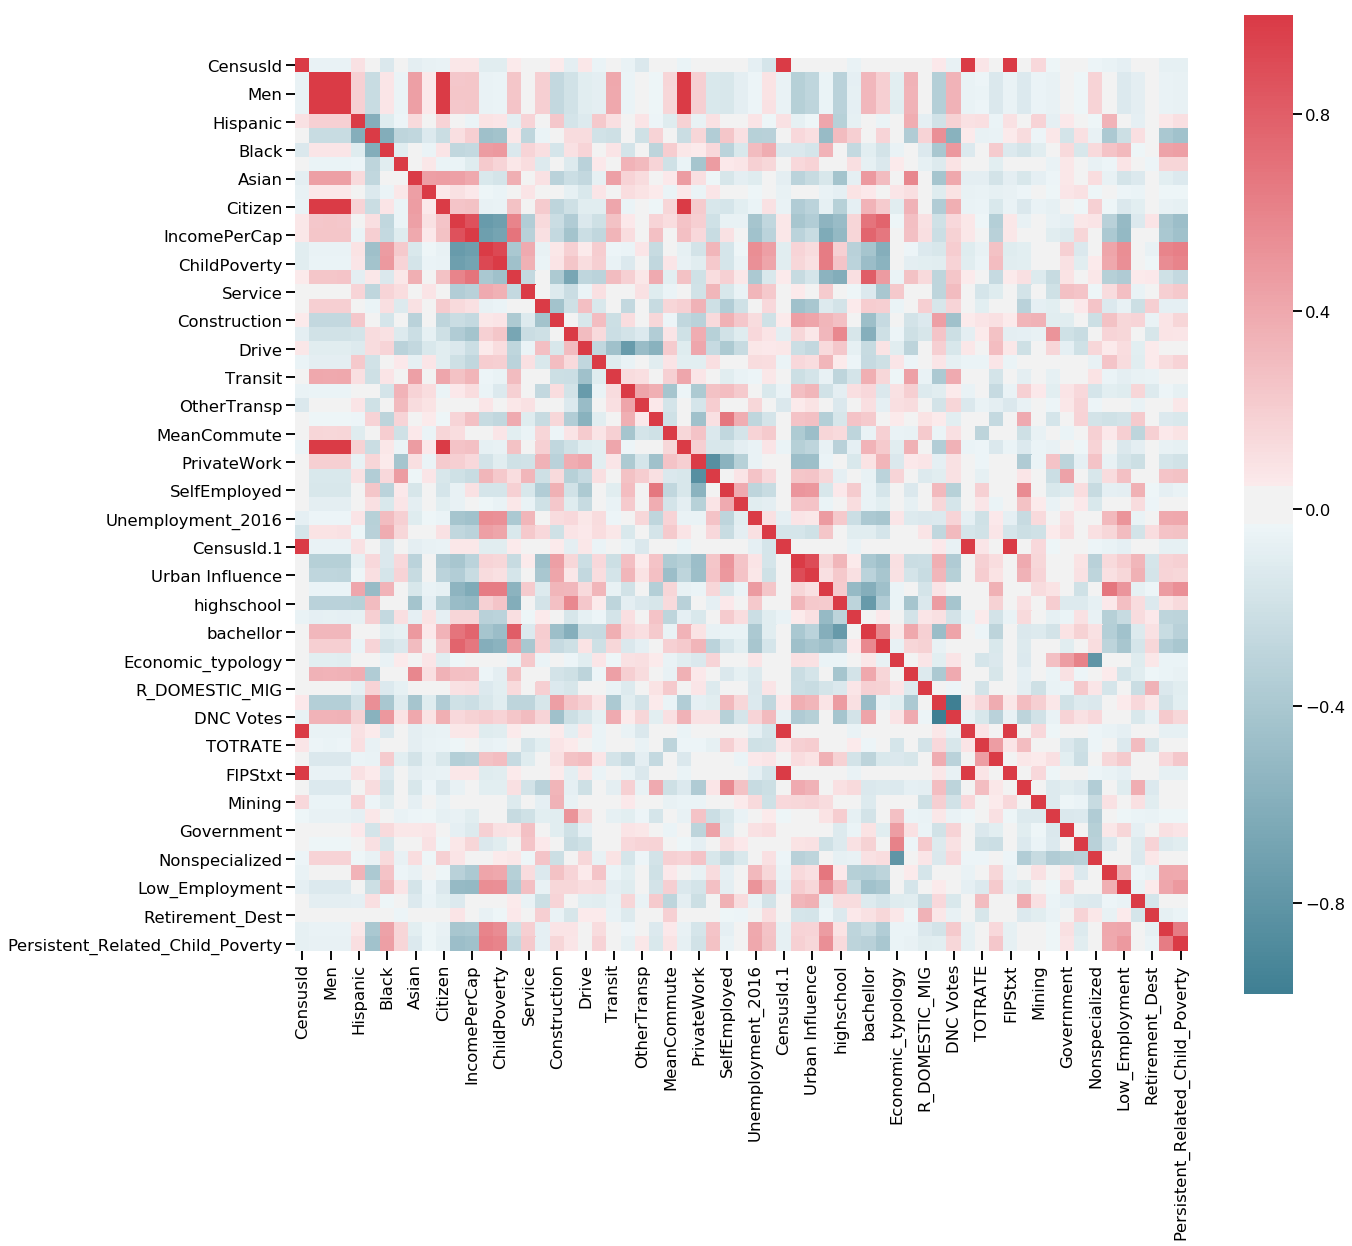

In [25]:
fig, ax = plt.subplots(figsize=(20, 18))
corr = df.loc[:, (df.columns)].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
fig.savefig('all_corr.png', bbox_inches = "tight")
plt.show()

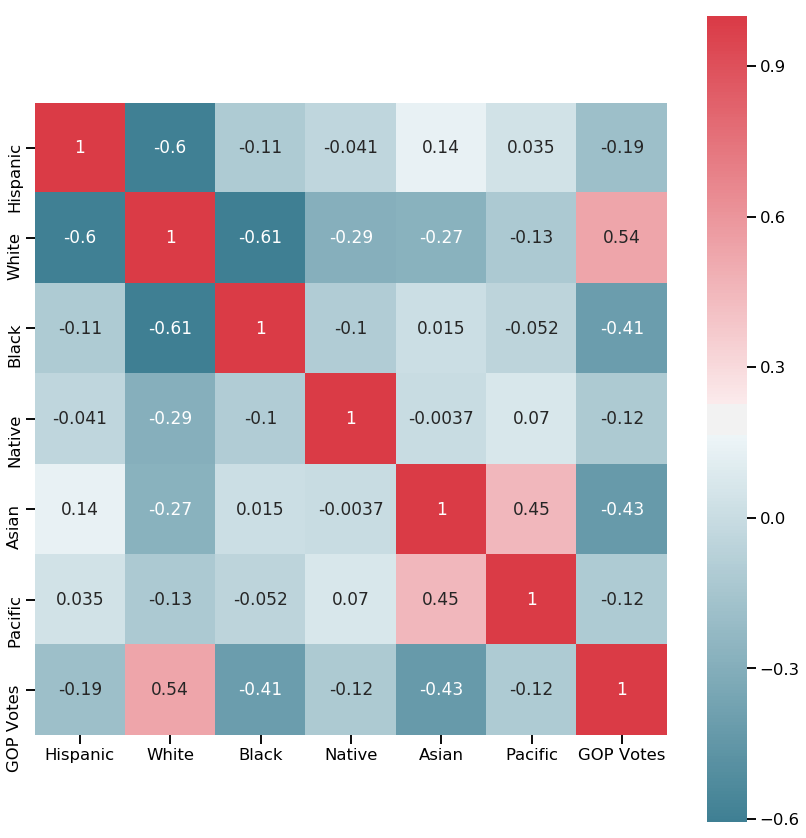

In [26]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.tight_layout()
corr = df.loc[:, (df.columns).isin(['Hispanic','White','Black','Native','Asian','Pacific','GOP Votes'])].corr()
sns.heatmap(corr, annot=True, annot_kws={"size": 17}, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
fig.savefig('race.png', bbox_inches = "tight")

plt.show()

I am going to create a new column that will join Native, Asian and Pacific Column and the rest of minorities that are not account for and I will drop those columns.

In [27]:
df1 = df[:].copy()

In [28]:
df1['Other_Min'] = 100 - (df1.White + df1.Black + df1.Hispanic)

In [29]:
df1.sample(5)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Nonspecialized,Low_Education,Low_Employment,Pop_Loss,Retirement_Dest,Persistent_Poverty,Persistent_Related_Child_Poverty,Name,Division,Other_Min
334,12033,Florida,Escambia,306327,152196,154131,5.3,65.6,21.4,0.4,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Florida,South Atlantic Division,7.7
2041,39001,Ohio,Adams,28229,13957,14272,0.9,96.7,0.4,0.2,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,Ohio,East North Central Division,2.0
3051,55013,Wisconsin,Burnett,15334,7845,7489,1.6,90.6,0.5,4.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wisconsin,East North Central Division,7.3
2071,39061,Ohio,Hamilton,804194,386561,417633,2.8,66.8,25.6,0.1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,Ohio,East North Central Division,4.8
284,8081,Colorado,Moffat,13117,6830,6287,14.3,82.2,0.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Colorado,Mountain Division,3.0


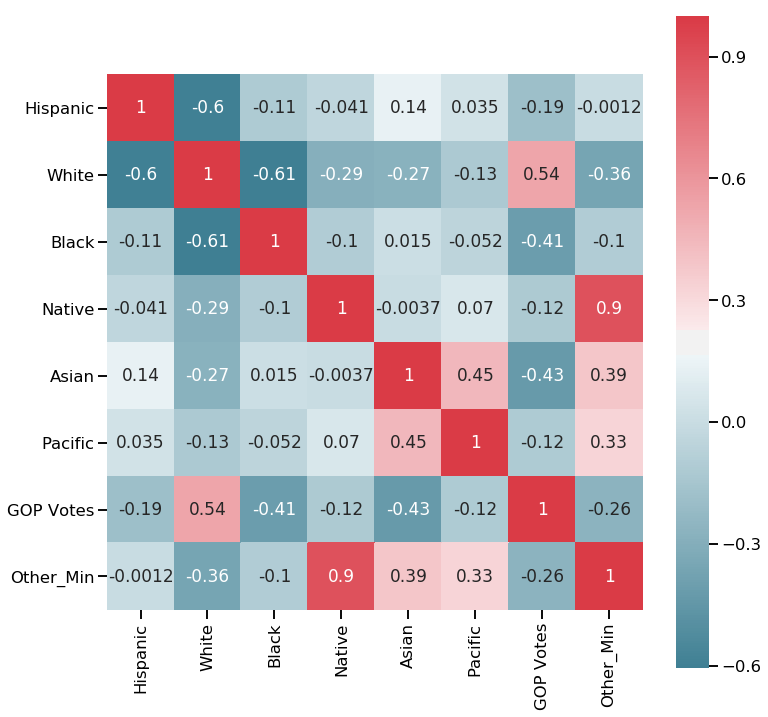

In [30]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df1.loc[:, (df1.columns).isin(['Hispanic','White','Black','Native','Asian','Pacific','Other_Min','GOP Votes'])].corr()
sns.heatmap(corr,annot=True,annot_kws={"size": 17}, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
f.savefig('race2.png', bbox_inches = "tight")


plt.show()

It looks like higher share of White population is positively correlated to GOP percentage of votes, and negatively correlated to Black, Other minorities and to a lesser extent to Hispanic

In [31]:
#I am going to create new column with the Gender share instead of keeping one for Men and one for Women
df1['gender'] = df1.Men / (df1.Men + df1.Women)

In [32]:
#I am dropping the Citizen column as it is basically the same than TotalPop
df1 = df1.drop(['Citizen'], axis=1)

In [33]:
df1.loc[:, (df1.columns).isin(['Income','IncomePerCap','Med_HH_Income'])].describe()

,Income,IncomePerCap,Med_HH_Income
count,3140.000000,3140.000000,3140.000000
mean,46826.260828,24335.283121,89.649236
std,12247.355518,5816.098525,19.887775
min,19328.000000,8292.000000,41.000000
25%,38826.750000,20471.000000,76.700000
50%,45094.500000,23577.000000,87.000000
75%,52247.750000,27138.000000,99.400000
max,123453.000000,65600.000000,244.800000


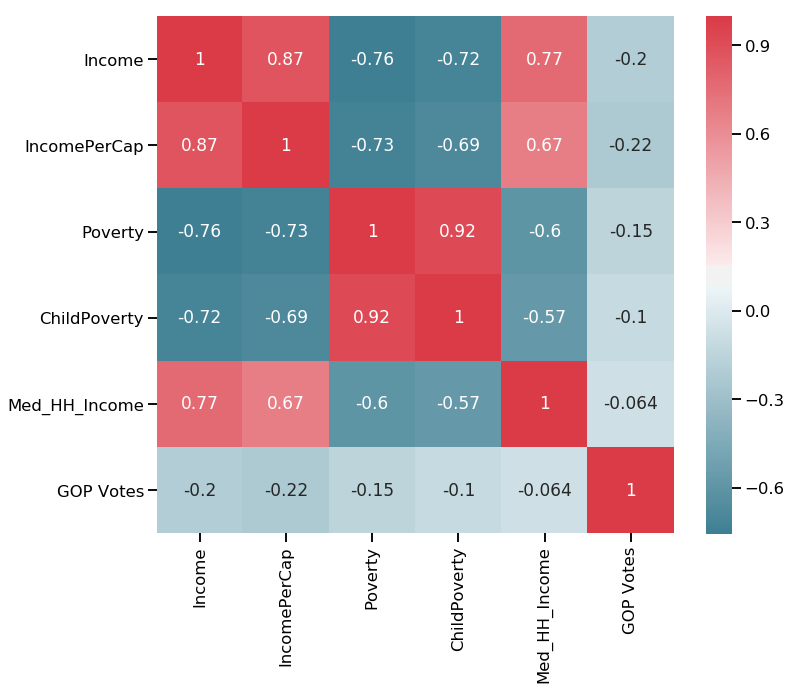

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.tight_layout()

corr = df1.loc[:, (df1.columns).isin(['Income','IncomePerCap','Med_HH_Income','Poverty','ChildPoverty','GOP Votes'])].corr()
sns.heatmap(corr,annot=True, annot_kws={"size": 17},mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
fig.savefig('economics.png', bbox_inches = "tight")

plt.show()

I am going to drop the Income column (very correlated to IncomePerCap but less correlated to gop votes) and the same for ChildPoverty (very correlated to Poverty but less to GOP votes than Poverty)

In [35]:
df1 = df1.drop(['Income', 'ChildPoverty'], axis=1)

In [36]:
#These 5 columns are complimentary, the add up to 100%
df1.loc[:, (df1.columns).isin(['Professional','Service','Office', 'Construction', 'Production' ])].describe()

,Professional,Service,Office,Construction,Production
count,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000
mean,31.042707,18.254682,22.133599,12.745796,15.823408
std,6.394765,3.572878,3.119788,4.237579,5.750656
min,13.500000,5.000000,4.100000,1.700000,0.000000
25%,26.700000,15.900000,20.200000,9.800000,11.575000
50%,30.000000,18.000000,22.400000,12.200000,15.400000
75%,34.425000,20.200000,24.300000,15.000000,19.400000
max,74.000000,36.600000,35.400000,40.300000,55.600000


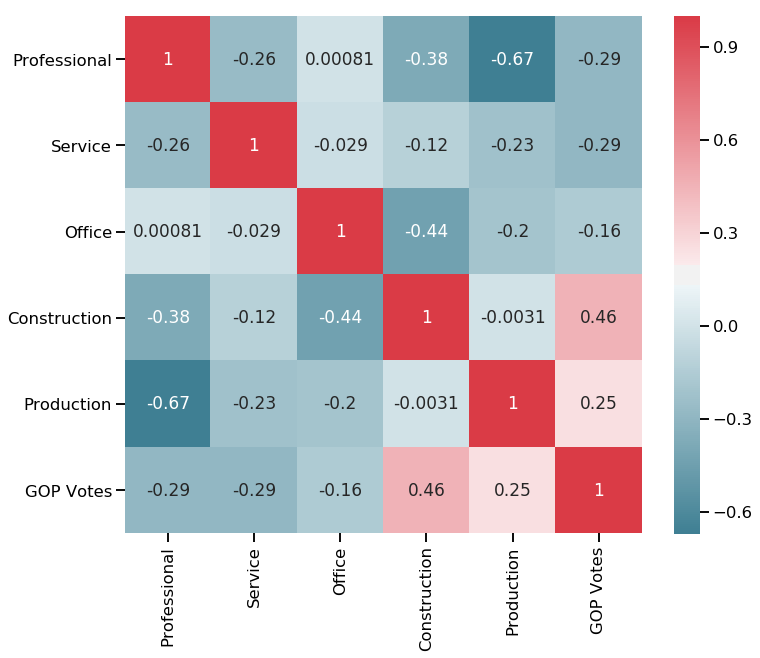

In [37]:
f, ax = plt.subplots(figsize=(10, 8))
plt.tight_layout()

corr = df1.loc[:, (df1.columns).isin(['Professional','Service','Office', 'Construction', 'Production','GOP Votes'])].corr()
sns.heatmap(corr,annot=True, annot_kws={"size": 17},mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
f.savefig('jobs.png', bbox_inches = "tight")

plt.show()

it looks like Contruction and Production are positively correlated to GOP votes and Professional, Service and to a lesser extent Office are negatively correlated to GOP Votes. I am going to keep all this variables.

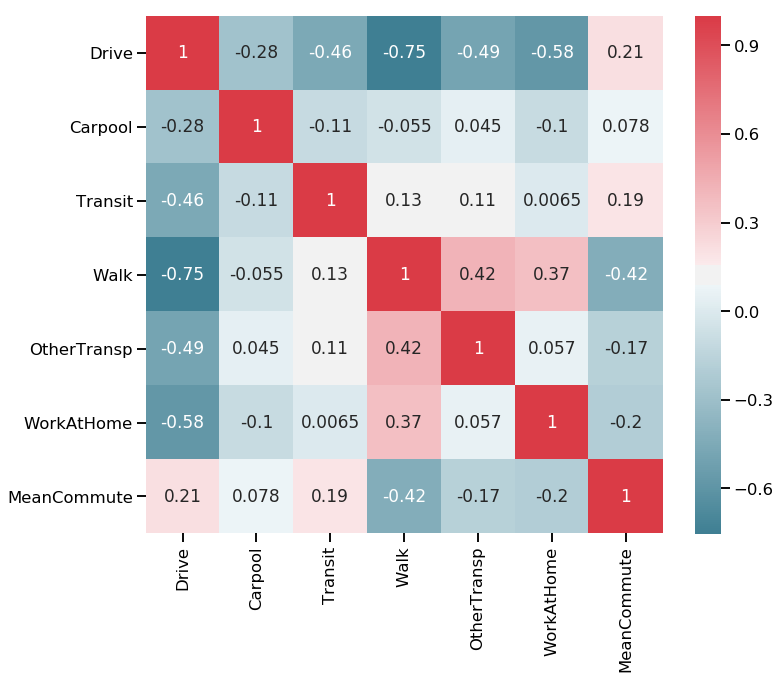

In [38]:
# These are also complimentary and add up to 100%
f, ax = plt.subplots(figsize=(10, 8))
plt.tight_layout()

corr = df1.loc[:, (df1.columns).isin(['Drive','Carpool','Transit', 'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute'  ])].corr()
sns.heatmap(corr,annot=True, annot_kws={"size": 17},mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
f.savefig('workplace.png', bbox_inches = "tight")

plt.show()

I am going to leave all these variables for now.

In [39]:
df1.loc[:, (df1.columns).isin(['Employed','PrivateWork','PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment_2016', 'Unemployment_var'])].describe()

,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment_2016,Unemployment_var
count,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000
mean,4.641581e+04,74.461306,17.324904,7.922261,0.291561,5.232452,2.577930
std,1.514772e+05,7.704158,6.298161,3.932902,0.458472,1.881020,2.805112
min,6.200000e+01,29.500000,5.800000,0.000000,0.000000,1.700000,-7.300000
25%,4.532000e+03,70.900000,13.075000,5.400000,0.100000,4.000000,0.800000
50%,1.065700e+04,75.850000,16.100000,6.900000,0.200000,4.900000,2.400000
75%,2.927150e+04,79.800000,20.100000,9.400000,0.300000,6.100000,4.100000
max,4.635465e+06,88.300000,66.200000,36.600000,9.800000,23.600000,24.900000


Employed is the absolut number of workers in that county. Instead of jusing that variable (that is going to be very correlated to population), I am going to create a new variable **LFRP** (Labor Force Participation Rate) by dividing employed by population and drop Employed.

In [40]:
df1['LFPR'] = df1.Employed/df1.TotalPop

In [41]:
df1 = df1.drop(['CensusId.1', 'Employed'], axis=1)

In [42]:
df1.loc[:, (df1.columns).isin(['Employed','PrivateWork','PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment_2016', 'Unemployment_var','LFPR'])].describe()

,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment_2016,Unemployment_var,LFPR
count,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000
mean,74.461306,17.324904,7.922261,0.291561,5.232452,2.577930,0.433662
std,7.704158,6.298161,3.932902,0.458472,1.881020,2.805112,0.065177
min,29.500000,5.800000,0.000000,0.000000,1.700000,-7.300000,0.165677
25%,70.900000,13.075000,5.400000,0.100000,4.000000,0.800000,0.390159
50%,75.850000,16.100000,6.900000,0.200000,4.900000,2.400000,0.436696
75%,79.800000,20.100000,9.400000,0.300000,6.100000,4.100000,0.481985
max,88.300000,66.200000,36.600000,9.800000,23.600000,24.900000,0.762409


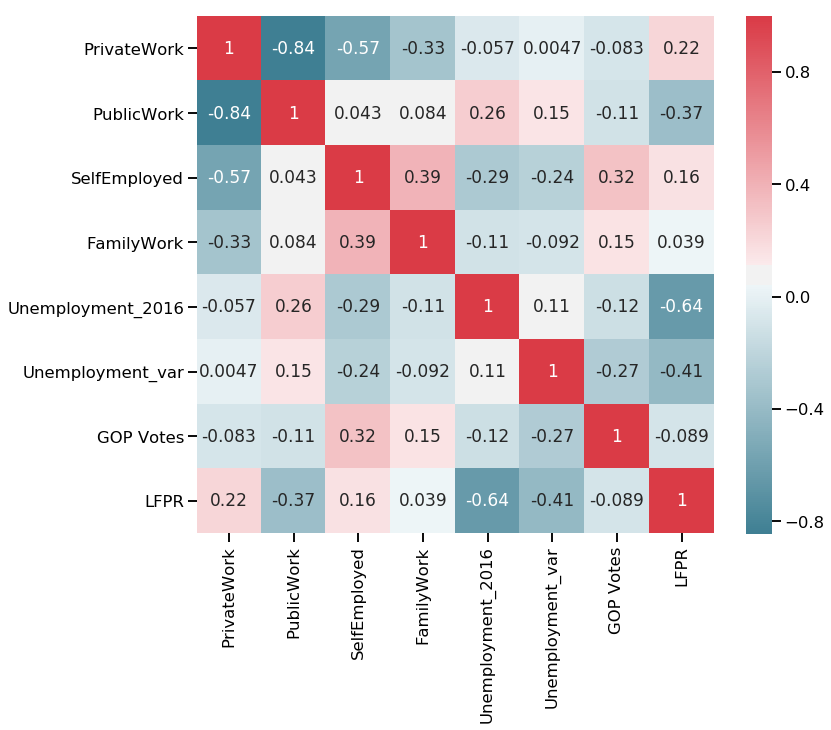

In [43]:
f, ax = plt.subplots(figsize=(10, 8))
plt.tight_layout()

corr = df1.loc[:, (df1.columns).isin(['PrivateWork','PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment_2016', 'Unemployment_var','LFPR','GOP Votes'])].corr()
sns.heatmap(corr,annot=True, annot_kws={"size": 17},mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
f.savefig('employer.png', bbox_inches = "tight")

plt.show()

I am going to keep all these variables for now

In [44]:
df1.loc[:, (df1.columns).isin(['Rural-urban','Urban Influence','Economic_typology'])].describe()

,Rural-urban,Urban Influence,Economic_typology
count,3140.000000,3140.000000,3140.000000
mean,5.007962,5.266561,1.807962
std,2.708099,3.497867,1.818912
min,1.000000,1.000000,0.000000
25%,2.000000,2.000000,0.000000
50%,6.000000,5.000000,1.000000
75%,7.000000,8.000000,3.000000
max,9.000000,12.000000,5.000000


Rural-Urban and Urban Influence provide a numerical score to a County based on how Rural or Urban it is. 1 means a pure Urban County while higher score means more rural

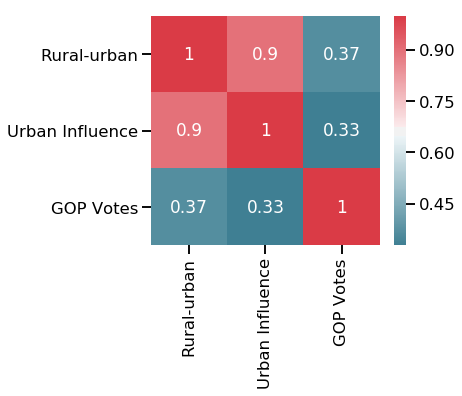

In [45]:
f, ax = plt.subplots(figsize=(5, 4))
plt.tight_layout()

corr = df1.loc[:, (df1.columns).isin(['Rural-urban','Urban Influence','GOP Votes'])].corr()
sns.heatmap(corr,annot=True,annot_kws={"size": 17}, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
f.savefig('rural.png', bbox_inches = "tight")

plt.show()

Both variables are very correlated, so I am dropping Urban Influence that is less correlated to the target variable


In [46]:
df1 = df1.drop(['Urban Influence'], axis=1)

In [47]:
df1.loc[:, (df1.columns).isin(['less_highschool','highschool','some_college','bachellor'])].describe()

,less_highschool,highschool,some_college,bachellor
count,3140.000000,3140.000000,3140.000000,3140.000000
mean,14.188714,34.574802,30.437947,20.798536
std,6.542060,7.072006,5.125282,9.140121
min,1.279000,6.464000,11.278000,2.985000
25%,9.271500,30.147250,26.925500,14.431250
50%,12.748000,34.925000,30.491000,18.547500
75%,18.281500,39.601250,33.922750,24.704750
max,51.479000,54.642000,47.428000,80.210000


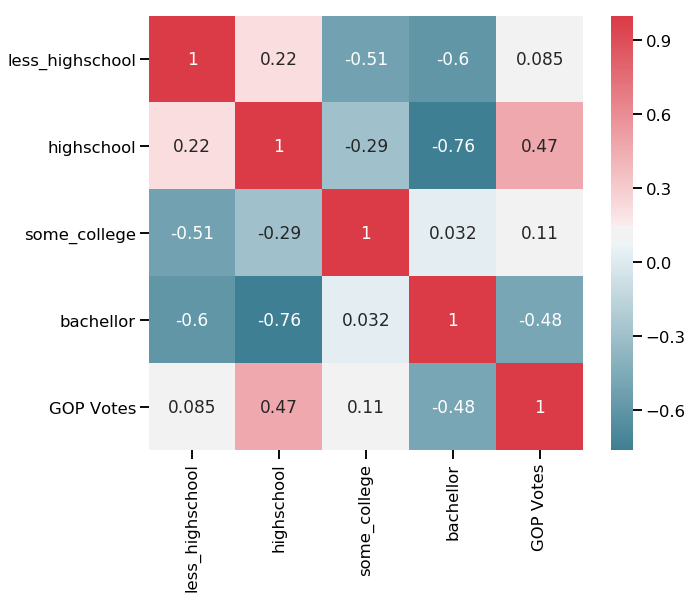

In [48]:
f, ax = plt.subplots(figsize=(10, 8))
f.autolayout : True

corr = df1.loc[:, (df1.columns).isin(['less_highschool','highschool','some_college','bachellor','GOP Votes'])].corr()
sns.heatmap(corr,annot=True,annot_kws={"size": 17}, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
f.savefig('education.png', bbox_inches = "tight")

plt.show()

I am going to keep all these variable for now.

In [49]:
df1.loc[:, (df1.columns).isin(['R_INTERNATIONAL_MIG','R_DOMESTIC_MIG'])].describe()

,R_INTERNATIONAL_MIG,R_DOMESTIC_MIG
count,3140.000000,3140.000000
mean,1.216545,-1.301440
std,2.029528,13.109430
min,-1.645278,-123.447462
25%,0.093837,-7.341499
50%,0.573566,-1.761895
75%,1.523053,4.478653
max,21.962819,210.672596


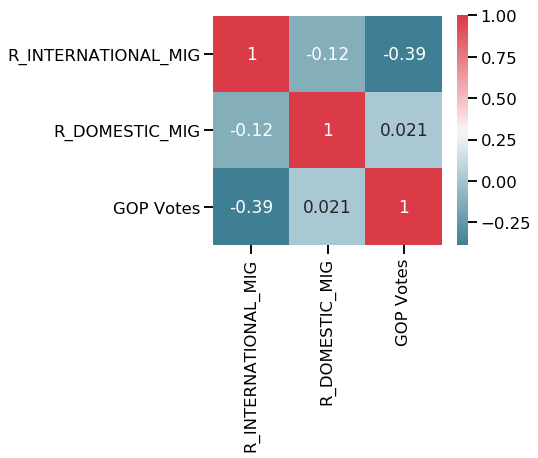

In [50]:
f, ax = plt.subplots(figsize=(5, 4))
plt.tight_layout()

corr = df1.loc[:, (df1.columns).isin(['R_INTERNATIONAL_MIG','R_DOMESTIC_MIG','GOP Votes'])].corr()
sns.heatmap(corr,annot=True,annot_kws={"size": 17}, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
f.savefig('inmigrants.png', bbox_inches = "tight")

plt.show()

I am going to keep Internation Mig but I am going to drop Domestic Mig. 

In [51]:
df1 = df1.drop(['R_DOMESTIC_MIG'], axis=1)       

In [52]:
df1.loc[:, (df1.columns).isin(['TOTRATE','EVANRATE'])].describe()

,TOTRATE,EVANRATE
count,3140.000000,3140.000000
mean,513.986862,231.205123
std,181.929482,163.032737
min,0.000000,0.000000
25%,384.292222,106.114722
50%,497.198889,186.915000
75%,623.582500,331.954167
max,1924.608889,1308.690000


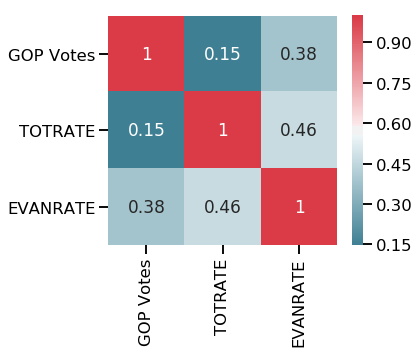

In [53]:
f, ax = plt.subplots(figsize=(5, 4))
plt.tight_layout()

corr = df.loc[:, (df.columns).isin(['TOTRATE','EVANRATE','GOP Votes'])].corr()
sns.heatmap(corr,annot=True,annot_kws={"size": 17}, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
f.savefig('religion.png', bbox_inches = "tight")

plt.show()

I am going to keep both variables for now

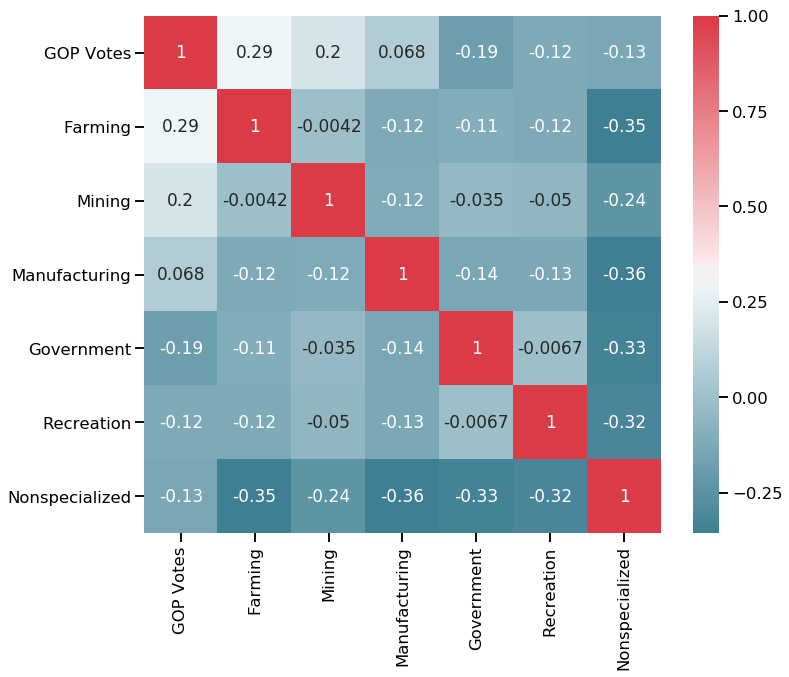

In [54]:
f, ax = plt.subplots(figsize=(10, 8))
plt.tight_layout()

corr = df1.loc[:, (df1.columns).isin(['Farming','Mining','Manufacturing','Government','Recreation','Nonspecialized','GOP Votes'])].corr()
sns.heatmap(corr,annot=True, annot_kws={"size": 17},mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
f.savefig('economics_2.png', bbox_inches = "tight")

plt.show()

I am keeping all these features for now

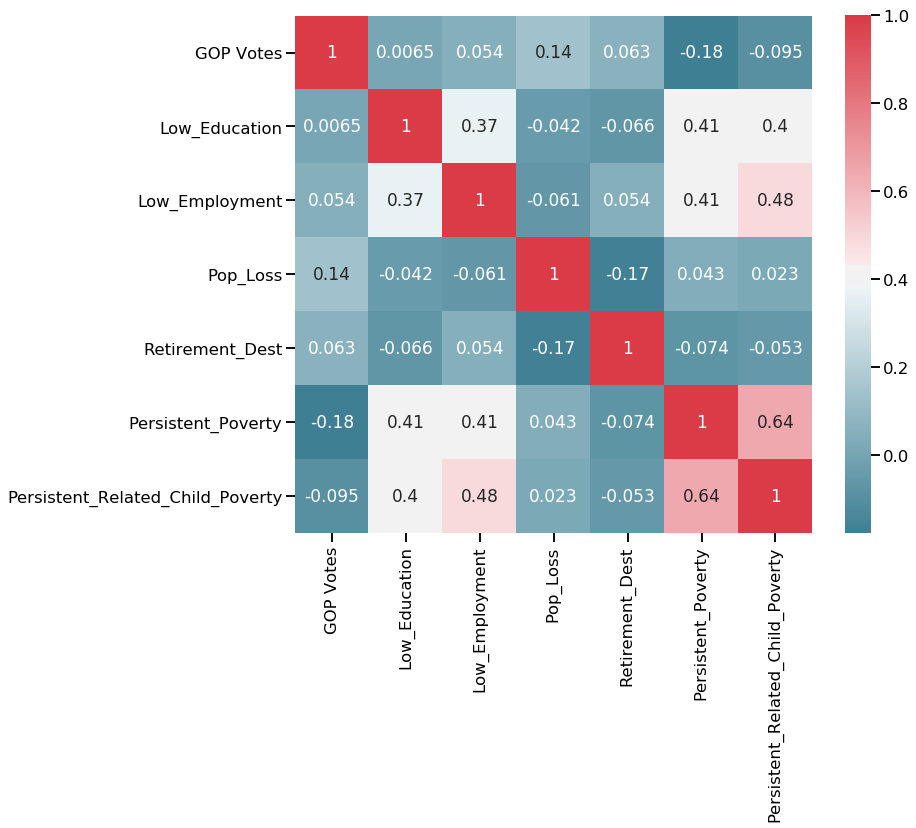

In [55]:
f, ax = plt.subplots(figsize=(10, 8))
plt.tight_layout()

corr = df1.loc[:, (df1.columns).isin(['Low_Education','Low_Employment','Pop_Loss','Retirement_Dest','Persistent_Poverty','Persistent_Related_Child_Poverty','GOP Votes'])].corr()
sns.heatmap(corr,annot=True,annot_kws={"size": 17}, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
f.savefig('socio_economics.png', bbox_inches = "tight")

plt.show()

I am going to drop Persitant Child Povery as it is very correlated with persistant poverty and less correlated to GOP votes

In [56]:
df1 = df1.drop(['Persistent_Related_Child_Poverty'], axis=1)     

I am going to create a new target variable calculating the difference between GOP votes and DNC Votes

In [57]:
df1['vote_dif'] = df1['GOP Votes'] - df1['DNC Votes']

In [58]:
df1.columns.values

array(['CensusId', 'State', 'County', 'TotalPop', 'Men', 'Women',
       'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',
       'IncomePerCap', 'Poverty', 'Professional', 'Service', 'Office',
       'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'PrivateWork',
       'PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment_2016',
       'Unemployment_var', 'Rural-urban', 'less_highschool', 'highschool',
       'some_college', 'bachellor', 'Med_HH_Income', 'Economic_typology',
       'R_INTERNATIONAL_MIG', 'GOP Votes', 'DNC Votes', 'FIPS', 'TOTRATE',
       'EVANRATE', 'FIPStxt', 'Farming', 'Mining', 'Manufacturing',
       'Government', 'Recreation', 'Nonspecialized', 'Low_Education',
       'Low_Employment', 'Pop_Loss', 'Retirement_Dest',
       'Persistent_Poverty', 'Name', 'Division', 'Other_Min', 'gender',
       'LFPR', 'vote_dif'], dtype=object)

In [59]:
df1.sample(5)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Low_Employment,Pop_Loss,Retirement_Dest,Persistent_Poverty,Name,Division,Other_Min,gender,LFPR,vote_dif
50,1101,Alabama,Montgomery,228138,108296,119842,3.4,36.9,55.8,0.2,...,0.0,0.0,0.0,0.0,Alabama,East South Central Division,3.9,0.474695,0.434640,-0.261610
118,5017,Arkansas,Chicot,11353,5577,5776,5.3,39.5,53.9,0.4,...,1.0,1.0,0.0,1.0,Arkansas,West South Central Division,1.3,0.491236,0.331983,-0.152808
1090,21199,Kentucky,Pulaski,63635,31151,32484,2.3,94.5,0.9,0.1,...,1.0,0.0,0.0,0.0,Kentucky,East South Central Division,2.3,0.489526,0.403379,0.667214
952,20133,Kansas,Neosho,16423,8055,8368,4.9,90.7,1.0,0.3,...,0.0,1.0,0.0,0.0,Kansas,West North Central Division,3.4,0.490471,0.475918,0.467566
2209,41007,Oregon,Clatsop,37382,18526,18856,8.1,86.4,0.7,0.3,...,0.0,0.0,0.0,0.0,Oregon,Pacific Division,4.8,0.495586,0.450564,-0.060855


I am going to drop the features that had low correlation with the election results or features that were substituted by new features. 

In [60]:
df1 = df1.drop(['CensusId','Men', 'Women','Native','Asian','Pacific','GOP Votes','DNC Votes', 'FIPS','Name','FIPStxt','Economic_typology'], axis=1)            

In [61]:
df1.columns.values

array(['State', 'County', 'TotalPop', 'Hispanic', 'White', 'Black',
       'IncomePerCap', 'Poverty', 'Professional', 'Service', 'Office',
       'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'PrivateWork',
       'PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment_2016',
       'Unemployment_var', 'Rural-urban', 'less_highschool', 'highschool',
       'some_college', 'bachellor', 'Med_HH_Income',
       'R_INTERNATIONAL_MIG', 'TOTRATE', 'EVANRATE', 'Farming', 'Mining',
       'Manufacturing', 'Government', 'Recreation', 'Nonspecialized',
       'Low_Education', 'Low_Employment', 'Pop_Loss', 'Retirement_Dest',
       'Persistent_Poverty', 'Division', 'Other_Min', 'gender', 'LFPR',
       'vote_dif'], dtype=object)

In [62]:
df1.sample(3)

,State,County,TotalPop,Hispanic,White,Black,IncomePerCap,Poverty,Professional,Service,...,Low_Education,Low_Employment,Pop_Loss,Retirement_Dest,Persistent_Poverty,Division,Other_Min,gender,LFPR,vote_dif
1946,North Carolina,Martin,23729,3.5,51.9,43.5,19032,21.3,29.8,17.2,...,0.0,1.0,0.0,0.0,1.0,South Atlantic Division,1.1,0.471406,0.382612,0.005062
2557,Texas,Cherokee,51167,21.9,61.6,14.4,19420,22.1,26.9,22.4,...,1.0,1.0,0.0,0.0,0.0,West South Central Division,2.1,0.510055,0.385581,0.564637
257,Colorado,Custer,4303,2.7,91.6,3.0,22661,17.4,24.2,25.6,...,0.0,1.0,0.0,1.0,0.0,Mountain Division,2.7,0.499187,0.323030,0.411880


After featuring selection, I have 48 columns left. Of those 48, 2 are the State and County name and one is the target variable. The actual number of features is 48, but one of them is categorical and I will create dummies for it.

# Forecasting

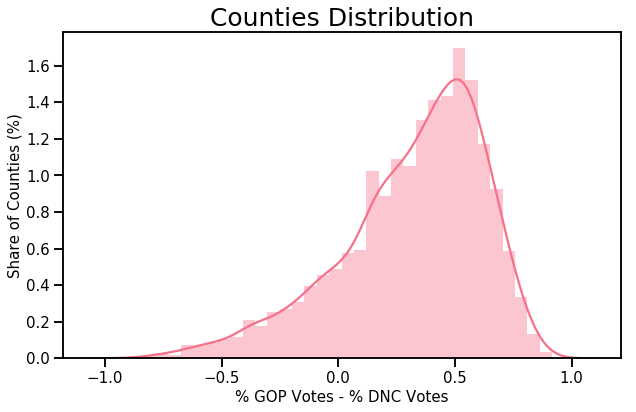

In [63]:
fig = plt.figure(figsize=(10,6))

sns.distplot(df1['vote_dif'])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title('Counties Distribution',fontsize=25)
plt.xlabel('% GOP Votes - % DNC Votes',fontsize=15)
plt.ylabel('Share of Counties (%)',fontsize=15)
fig.savefig('distribution.png', bbox_inches = "tight")

plt.show()

The distribution of the data has negative skewness, with a majority of counties voting Republican. The most common result was a Republican victory with close to 50% difference. 

In [64]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [65]:
X = df1.loc[:, ~(df1.columns).isin(['State','County','vote_dif'])]
y = df1.loc[:, (df1.columns).isin(['vote_dif'])]

I am going to create dummi features for the Division Feature

In [66]:
X =pd.get_dummies(X)

In [67]:
X.sample(5)

,TotalPop,Hispanic,White,Black,IncomePerCap,Poverty,Professional,Service,Office,Construction,...,LFPR,Division_East North Central Division,Division_East South Central Division,Division_Middle Atlantic Division,Division_Mountain Division,Division_New England Division,Division_Pacific Division,Division_South Atlantic Division,Division_West North Central Division,Division_West South Central Division
973,23274,58.3,33.7,3.5,20442,19.1,20.5,12.9,17.6,17.4,...,0.473962,0,0,0,0,0,0,0,1,0
2400,49874,1.7,94.0,1.0,35559,4.4,44.7,11.4,25.6,8.5,...,0.553856,0,0,0,0,0,0,0,1,0
1181,39723,1.2,95.9,0.6,28144,11.2,33.8,17.8,23.6,15.2,...,0.485109,0,0,0,0,1,0,0,0,0
3127,95431,14.0,79.2,2.8,30047,10.1,37.2,16.0,23.9,11.4,...,0.484182,0,0,0,1,0,0,0,0,0
1864,61399,3.4,91.9,1.8,24625,16.5,36.8,20.2,22.4,9.5,...,0.463591,0,0,1,0,0,0,0,0,0


# Regression

### Gradient Boosting Regressor


In [68]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y, random_state=42, test_size=0.2)

In [69]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import explained_variance_score


In [70]:
clf = GradientBoostingRegressor()
clf.fit(X_train_r,y_train_r)


rfrscore = cross_val_score(clf, X_train_r, y_train_r.values.ravel(), cv=5)
print (rfrscore)
print("rfrscore: %0.4f (+/- %0.4f)" % (rfrscore.mean(),rfrscore.std() * 2))

[0.84202649 0.82616947 0.8387202  0.81783407 0.8368952 ]
rfrscore: 0.8323 (+/- 0.0180)


The results for GradientBoost regressor without optimizations are better than expected. I am going to use Grid Search to try to optimize the results in a systematic way. 

In [71]:
# Initialize and fit the model.
clf_r1 = GradientBoostingRegressor()
from sklearn.metrics import make_scorer, explained_variance_score
from sklearn.model_selection import GridSearchCV



parameters = {'n_estimators': [100,200,300,500], 
              'min_samples_split':[2,4,6,8], 
              'max_depth':[2,3,4,6],
              'min_samples_leaf': [1,3,5],
              'learning_rate': [0.1,0.2,0.3]             }

acc_scorer = make_scorer(explained_variance_score)

grid_obj = GridSearchCV(clf_r1, parameters, scoring=acc_scorer,n_jobs=4)
grid_obj = grid_obj.fit(X_train_r, y_train_r.values.ravel())

# Set the clf to the best combination of parameters
clf_r1 = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf_r1.fit(X_train_r, y_train_r.values.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [72]:
rfrscore = cross_val_score(clf_r1, X_train_r, y_train_r.values.ravel(), cv=5)
print (rfrscore)
print("rfrscore: %0.4f (+/- %0.4f)" % (rfrscore.mean(),rfrscore.std() * 2))

[0.84748047 0.85375347 0.84291145 0.83513633 0.85838539]
rfrscore: 0.8475 (+/- 0.0163)


Through grid search I was able to optimaze a bit the result with an increase of 0.017 points in the score.  

In [73]:
predicted = clf_r1.predict(X_test_r)
predict_df = pd.DataFrame(data = predicted, columns= ['prediction'])
predict_df['actual'] = y_test_r.values.ravel()
residual = predict_df['actual']- predict_df['prediction']

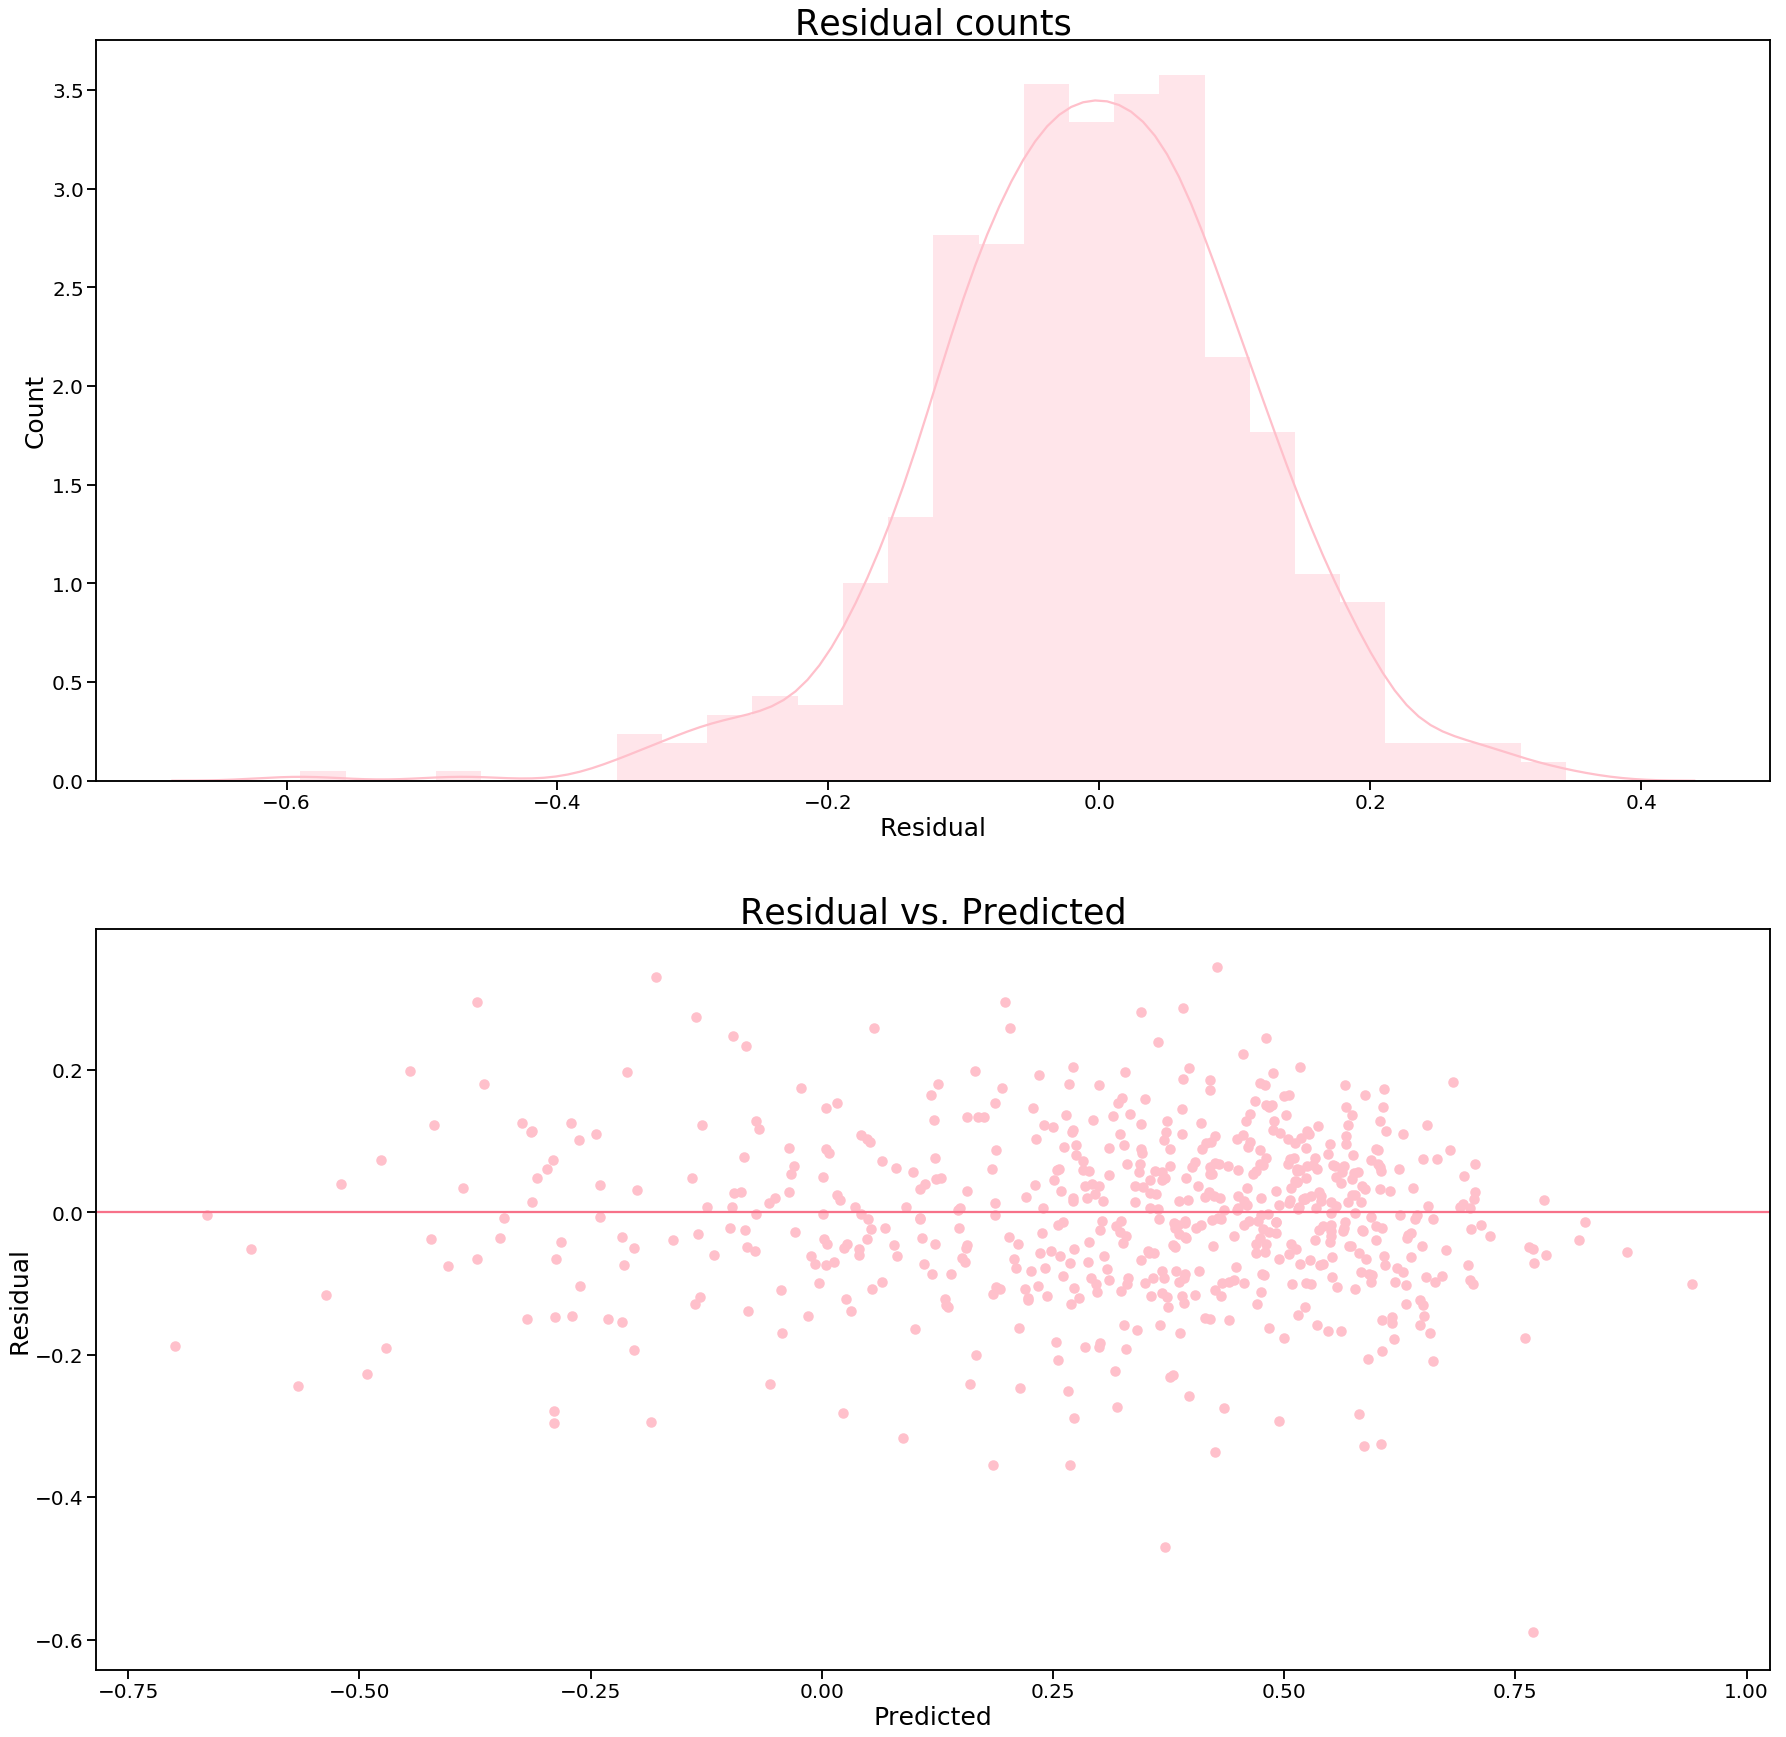

In [74]:
fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='pink')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='pink')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)
fig.savefig('regresion1.png', bbox_inches = "tight")

plt.show()

Looking at the first graphs above, the error on the model looks similar to a normal distribution, it doesn't seem like we have any big outliers in the data. 
Also, in the second graph we can see that the residuals are consistenly distributed accross the different predicted values. 

# Classification

After trying to forecast the percentage of votes for each party, I am going to try to forecast the winner of the elections for each one of the counties. 

In [75]:
from sklearn.ensemble import GradientBoostingClassifier


In [76]:
y_c = y

In [77]:
category = []
for index, row in y_c.iterrows():
    if y_c.vote_dif[index]<0:
        category.append('Dems')
    else:
        category.append('Rep')

In [78]:
y_c['Cat'] = category

In [79]:
y_c.sample(25)

,vote_dif,Cat
1954,0.346543,Rep
1263,0.299648,Rep
400,0.431720,Rep
1959,0.280819,Rep
1662,0.406472,Rep
1020,0.322259,Rep
546,-0.298716,Dems
222,-0.760892,Dems
587,0.350616,Rep
288,0.251886,Rep


I created a new target variable with the party that won the elections on each county using the Vote Difference variable.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y_c['Cat'],random_state=42, test_size=0.2)

In [81]:
y_test = y_test.reset_index()
y_test.sample()

,index,Cat
561,2115,Rep


I am going to use gradentboosting classifier and I am going to do systematicall optimization using grid search. 

In [82]:
# Initialize and fit the model.
clf_c1 = GradientBoostingClassifier()
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators': [100,300,500], 
              'min_samples_split':[4,8,16,32], 
              'max_depth':[4,6,8,10],
              'min_samples_leaf': [1,3,5],
              'learning_rate': [0.1,0.2,0.3]             }

acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf_c1, parameters, scoring=acc_scorer,n_jobs=4)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf_c1 = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf_c1.fit(X_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=8,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [83]:
predicted = clf_c1.predict(X_test)
predict_df = pd.DataFrame(data = predicted, columns= ['prediction'])
predict_df['actual'] = y_test["Cat"]
confusion_matrix(predict_df['actual'], predict_df['prediction'],labels=["Dems",'Rep'])

array([[ 76,  24],
       [ 12, 516]], dtype=int64)

Out of 628 counties on the testing data, 596 of them were classified right and 32 of them wrongly (94.90% accuracy). Of those 32 counties that were wrongly classified, 22 Republican counties were classified as Democrat and 10 Democrats were classied as Republican.

In [84]:
print ("Features sorted by their score:")
names = X_train.columns.values

feature_imp = (sorted(zip(map(lambda x: round(x, 4), clf_c1.feature_importances_), names), 
             reverse=True))
print(feature_imp)

Features sorted by their score:
[(0.2682, 'White'), (0.2028, 'bachellor'), (0.0983, 'Transit'), (0.0748, 'Construction'), (0.0411, 'MeanCommute'), (0.0287, 'Division_New England Division'), (0.0242, 'TotalPop'), (0.0198, 'Med_HH_Income'), (0.0196, 'Hispanic'), (0.018, 'Poverty'), (0.0172, 'EVANRATE'), (0.015, 'Unemployment_var'), (0.013, 'Service'), (0.0122, 'Professional'), (0.0121, 'Black'), (0.012, 'gender'), (0.012, 'LFPR'), (0.009, 'OtherTransp'), (0.0087, 'SelfEmployed'), (0.0086, 'Walk'), (0.0072, 'some_college'), (0.0072, 'TOTRATE'), (0.0068, 'Production'), (0.0065, 'Carpool'), (0.0063, 'highschool'), (0.0061, 'R_INTERNATIONAL_MIG'), (0.0058, 'Office'), (0.0054, 'WorkAtHome'), (0.0054, 'Drive'), (0.0045, 'IncomePerCap'), (0.004, 'Division_East North Central Division'), (0.0038, 'Other_Min'), (0.0036, 'Unemployment_2016'), (0.0026, 'less_highschool'), (0.0021, 'Rural-urban'), (0.0021, 'PublicWork'), (0.002, 'PrivateWork'), (0.0013, 'Division_West North Central Division'), (0.000

In [85]:
len(feature_imp)

56

In [86]:
feat_importances = pd.Series(clf_c1.feature_importances_, index=X_train.columns)
feat_importances2 = pd.DataFrame(data=feat_importances, columns=["Feature"])


In [87]:
feat_importances2.reset_index(level=0, inplace=True)



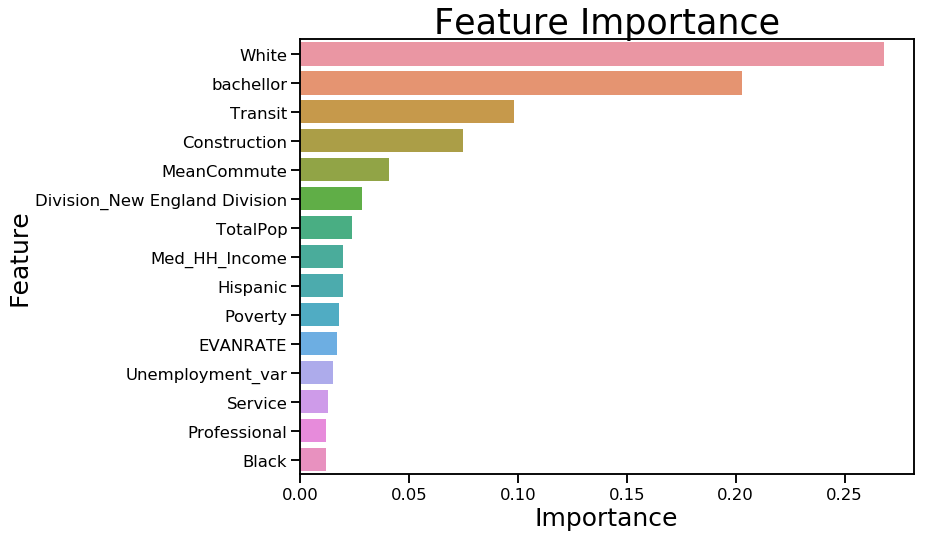

In [88]:
sns.set_context("talk")
sns.set_palette("husl")

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11, 8)
ax = sns.barplot(x="Feature",y="index", data =feat_importances2.sort_values("Feature",axis=0,ascending = False).iloc[:15])
plt.title('Feature Importance',fontsize=35)
plt.xlabel('Importance',fontsize=25)
plt.ylabel('Feature',fontsize=25)
fig.savefig('feature_importance.png', bbox_inches = "tight")


plt.show()

Some of the features have a very high weight on the results while others were barely or never used. I am going to remove some of those low impact features and run the code again, to see if that will help achieving better result. I am going to remove all variables with a score lower than 0.001, with the exception of the Division dummies features. 

## Removing features with low impact

In [89]:
X1 = df1.loc[:, ~(df1.columns).isin(['State','County','vote_dif','Manufacturing', 'Low_Education','Farming','Nonspecialized','Persistent_Poverty',
                                    'Pop_Loss','Government','Low_Employment','Retirement_Dest','Mining','Recreation'])]
y1 = df1.loc[:, (df1.columns).isin(['vote_dif'])]
X1 =pd.get_dummies(X1)

In [90]:
X1.sample(5)

,TotalPop,Hispanic,White,Black,IncomePerCap,Poverty,Professional,Service,Office,Construction,...,LFPR,Division_East North Central Division,Division_East South Central Division,Division_Middle Atlantic Division,Division_Mountain Division,Division_New England Division,Division_Pacific Division,Division_South Atlantic Division,Division_West North Central Division,Division_West South Central Division
2972,10363,2.9,92.2,0.2,24951,15.3,35.3,17.7,20.1,16.7,...,0.390813,0,0,0,0,0,1,0,0,0
2388,3375,1.4,97.4,0.0,29723,8.2,36.9,15.3,21.5,18.8,...,0.523852,0,0,0,0,0,0,0,1,0
2404,4701,4.8,83.4,0.6,25161,15.1,34.8,12.3,21.6,16.5,...,0.509253,0,0,0,0,0,0,0,1,0
117,27635,14.3,81.6,0.4,20195,18.3,27.5,16.7,19.1,12.7,...,0.414474,0,0,0,0,0,0,0,0,1
1850,27124,1.7,95.9,0.9,24772,12.1,29.3,17.3,18.4,17.9,...,0.441159,0,0,1,0,0,0,0,0,0


## Gradient Boosting Regressor


In [91]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X1, y1, random_state=42,test_size=0.2)

In [92]:
# Initialize and fit the model.
clf = GradientBoostingRegressor()
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV


parameters = {'n_estimators': [100,200,300,500], 
              'min_samples_split':[2,4,8,16,32], 
              'max_depth':[2,3,4,6,8],
              'min_samples_leaf': [1,3,4,5],
              'learning_rate': [0.1,0.2,0.3]             }

acc_scorer = make_scorer(explained_variance_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer,n_jobs=4)
grid_obj = grid_obj.fit(X_train_r, y_train_r.values.ravel())

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train_r, y_train_r.values.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=8, min_weight_fraction_leaf=0.0,
             n_estimators=300, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [93]:
rfrscore = cross_val_score(clf, X_train_r, y_train_r.values.ravel(), cv=5)
print (rfrscore)
print("rfrscore: %0.4f (+/- %0.4f)" % (rfrscore.mean(),rfrscore.std() * 2))

[0.84848611 0.8543141  0.84592265 0.8293229  0.85784216]
rfrscore: 0.8472 (+/- 0.0197)


After removing the number of features, the variance that the model can explain remains almost the same (a 0.003 points decrease) with a slight decreased on std (0.0014 points decrease). 

In [94]:
predicted = clf.predict(X_test_r)
predict_df = pd.DataFrame(data = predicted, columns= ['prediction'])
predict_df['actual'] = y_test_r.values.ravel()
residual = predict_df['actual']- predict_df['prediction']

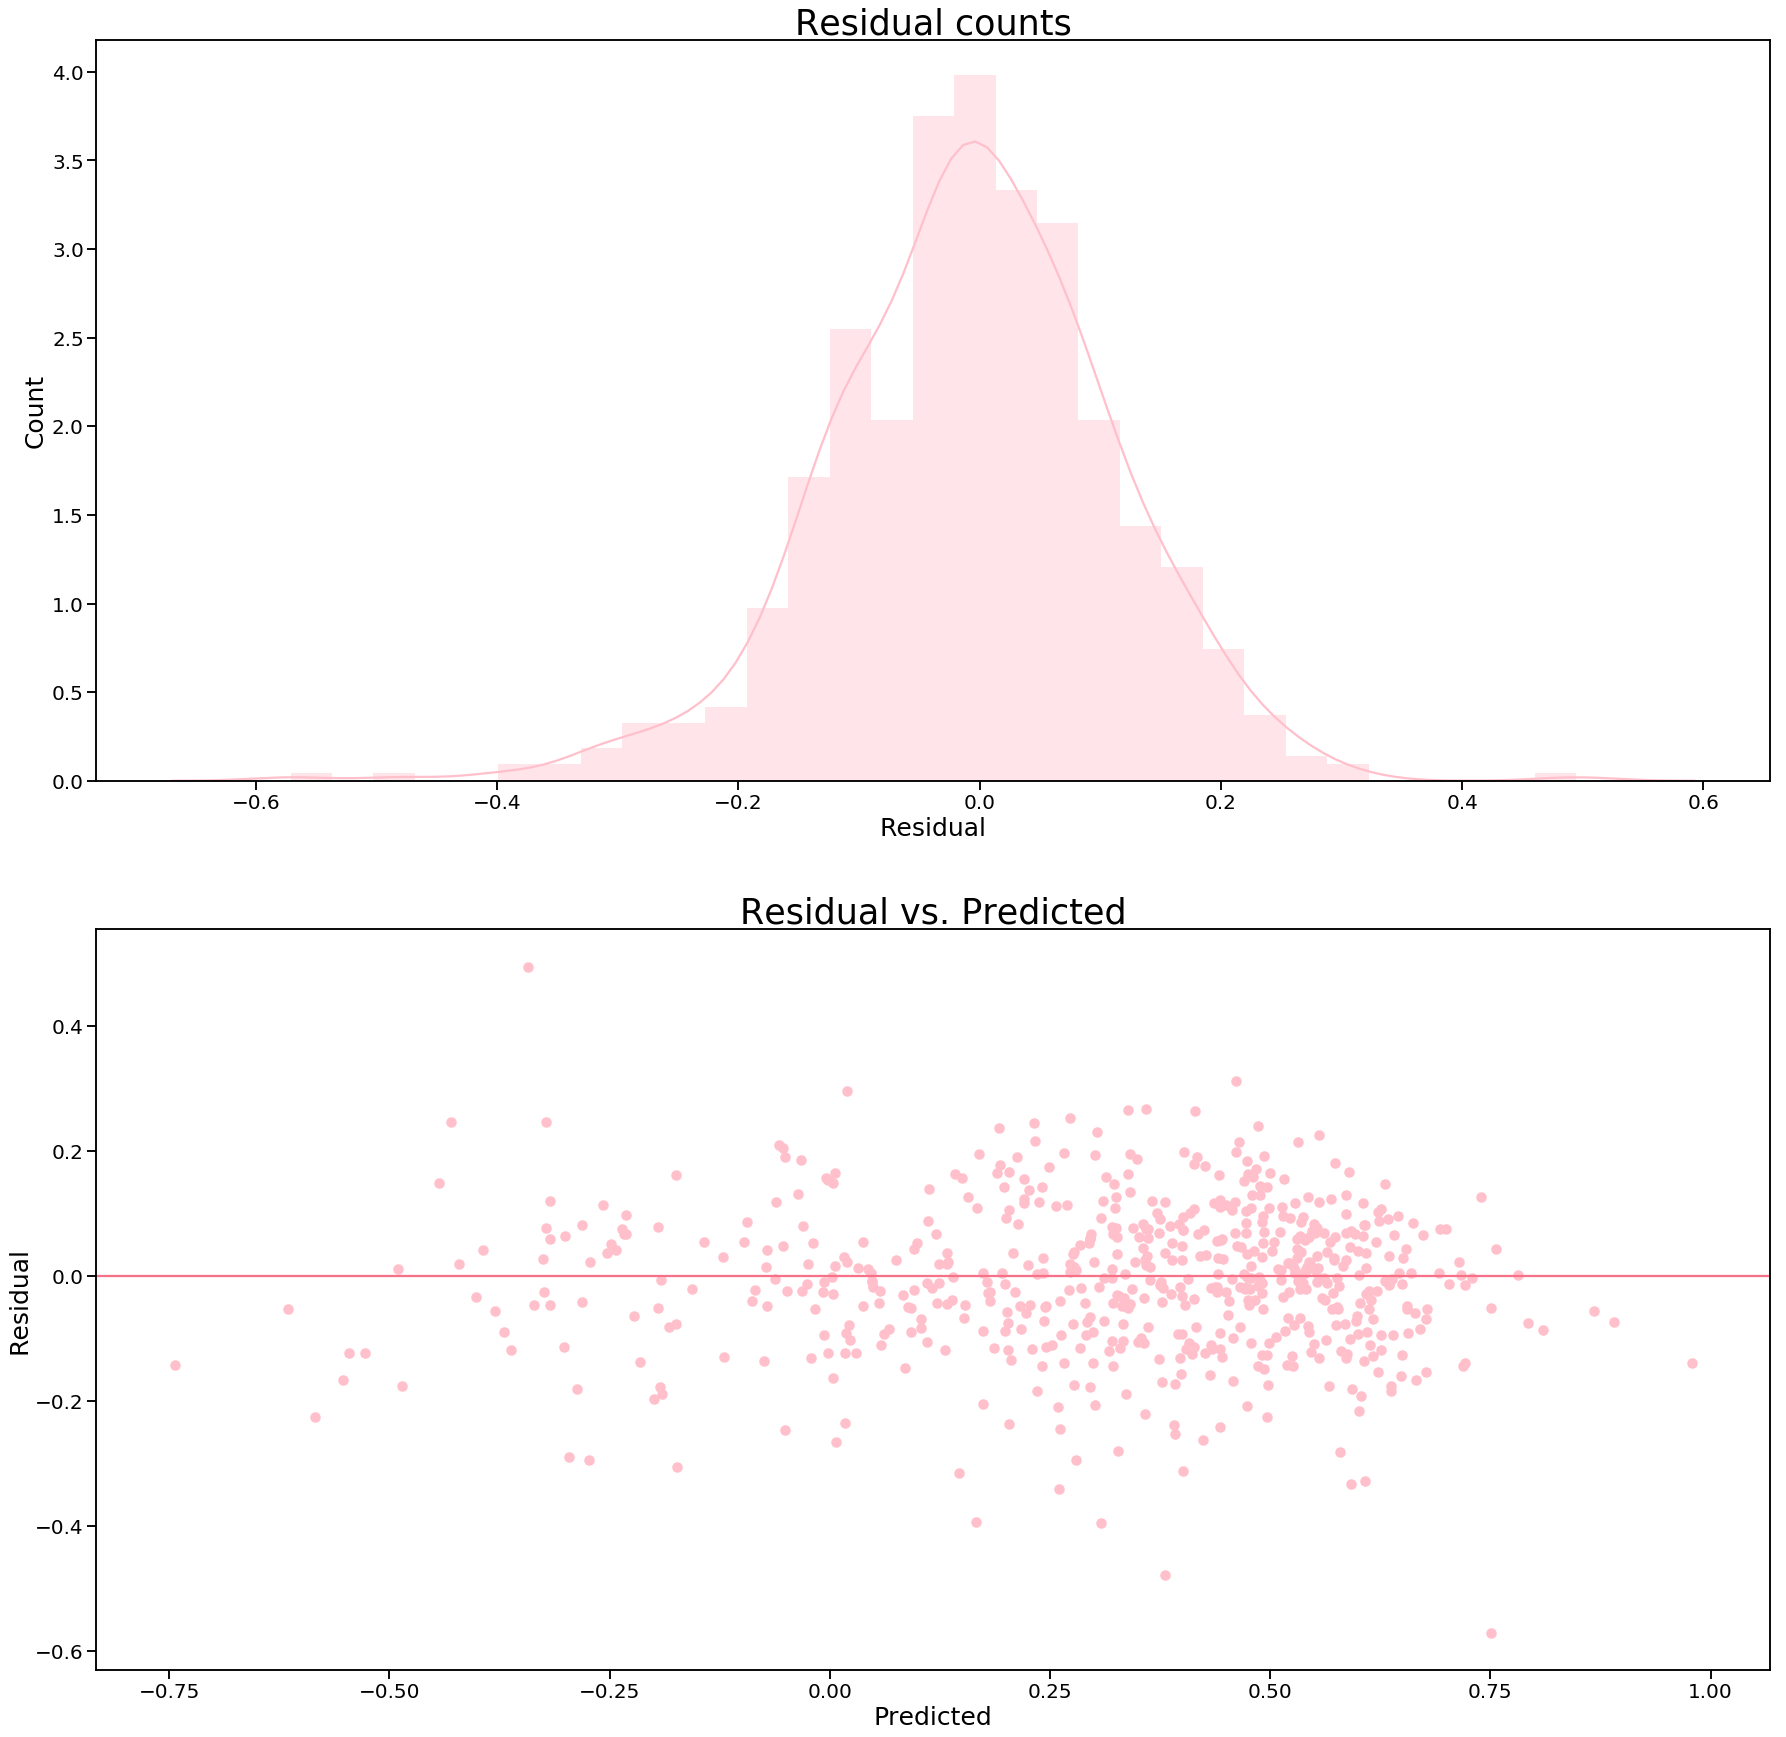

In [95]:
fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='pink')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='pink')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)
fig.savefig('regresion2.png', bbox_inches = "tight")


plt.show()

# Classification

In [96]:
y_c = y

In [97]:
category = []
for index, row in y_c.iterrows():
    if y_c.vote_dif[index]<0:
        category.append('Dems')
    else:
        category.append('Rep')

In [98]:
y_c['Cat'] = category

In [99]:
y_c.sample(25)

,vote_dif,Cat
1206,-0.809867,Dems
823,0.237505,Rep
574,0.650336,Rep
2655,0.905660,Rep
1381,0.153865,Rep
1005,0.498252,Rep
1151,0.102442,Rep
2866,0.278767,Rep
2524,0.503678,Rep
1162,0.508067,Rep


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y_c['Cat'],random_state=42, test_size=0.2)

In [101]:
y_test = y_test.reset_index()
y_test.sample()

,index,Cat
610,282,Rep


In [102]:
# Initialize and fit the model.
clf = GradientBoostingClassifier()
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV



parameters = {'n_estimators': [100,200,300,500], 
              'min_samples_split':[2,4,8,16,32], 
              'max_depth':[2,3,4,6,8],
              'min_samples_leaf': [1,3,4,5],
              'learning_rate': [0.1,0.2,0.3]             } 

acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer,n_jobs=4)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=32,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [103]:
predicted = clf.predict(X_test)
predict_df = pd.DataFrame(data = predicted, columns= ['prediction'])
predict_df['actual'] = y_test["Cat"]
confusion_matrix(predict_df['actual'], predict_df['prediction'],labels=["Dems",'Rep'])

array([[ 77,  23],
       [ 12, 516]], dtype=int64)

After reducing the number of variables, there was a small increase on the accuracy of the model (95.1%). 